# <a id='toc1_'></a>[FYS5419: Project 1](#toc0_)
## <a id='toc1_1_'></a>[Author: Oskar Ekeid Idland](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [FYS5419: Project 1](#toc1_)    
  - [Author: Oskar Ekeid Idland](#toc1_1_)    
- [Imports](#toc2_)    
- [Types](#toc3_)    
- [a)](#toc4_)    
  - [Functions](#toc4_1_)    
  - [Playing with Qubits](#toc4_2_)    
  - [Exploring Pauli Matrices](#toc4_3_)    
  - [Exploring Gates](#toc4_4_)    
  - [Bell States](#toc4_5_)    
    - [Creation by Applying Gates](#toc4_5_1_)    
    - [Direct Creation](#toc4_5_2_)    
    - [Acting on the Bell State with Gates](#toc4_5_3_)    
    - [Testing by Measuring Bell States](#toc4_5_4_)    
  - [Circuit and Measurements in Qiskit](#toc4_6_)    
  - [Conclusion](#toc4_7_)    
- [b)](#toc5_)    
  - [Functions](#toc5_1_)    
  - [Finding Eigenvalues](#toc5_2_)    
  - [Conclusion](#toc5_3_)    
- [c)](#toc6_)    
  - [Functions](#toc6_1_)    
  - [Comparing VQE and Exact Eigenvalues](#toc6_2_)    
  - [Conclusion](#toc6_3_)    
- [d)](#toc7_)    
  - [Functions](#toc7_1_)    
    - [Analytical Solution](#toc7_1_1_)    
      - [Using SymPy](#toc7_1_1_1_)    
      - [Using the Results from Above](#toc7_1_1_2_)    
  - [Plotting Energy and Entropy](#toc7_2_)    
  - [Conclusion](#toc7_3_)    
- [e)](#toc8_)    
  - [Functions](#toc8_1_)    
  - [Comparing VQE and Exact Eigenvalues](#toc8_2_)    
  - [Conclusion](#toc8_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [ ]:
### Regular imports ###
import warnings
import numpy as np
import sympy as sp
from time import time
from numba import njit
from tabulate import tabulate
import matplotlib.pyplot as plt
from dataclasses import dataclass
from numpy import float64, complex128, ndarray
from typing import Annotated, Literal, Callable

### Customizations ###
np.set_printoptions(precision=3, sign=' ')
plt.rcParams.update({'font.size': 12, 
                     'font.family': 'serif', 
                     'figure.figsize': (10, 6), 
                     'mathtext.fontset': 'cm',
                     'axes.prop_cycle': plt.cycler(color=["#3d0dce", 
                                                          "#ff1e1e", 
                                                          "#61ffa6",
                                                          "#86db0f",
                                                          "#f711ff",
                                                          "#64B5CD"]),
                     'lines.linewidth': 3,
                     'legend.fontsize': 10,
                    })
tensor_prod = np.kron

### Qiskit imports ###
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# <a id='toc3_'></a>[Types](#toc0_)

In [ ]:
### Matplotlib Figure type ###
Figure = Annotated[plt.Figure, "Figure"]

### Indexing types ###
Indexing_2qbit = Annotated[Literal[0, 1,], "Valid 2 qubit indexing"]
Indexing_3qbit = Annotated[Literal[0, 1, 2], "Valid 3 qubit indexing"]

### Vectors ###
Array2D   = Annotated[ndarray[2, float],   "2D array"]
Array2D_c = Annotated[ndarray[2, complex], "2D complex array"]

Array4D   = Annotated[ndarray[4, float],   "4D array"]
Array4D_c = Annotated[ndarray[4, complex], "4D complex array"]

### Matrices ###
Array2x2   = Annotated[ndarray[(ndarray[2, float], 
                                ndarray[2, float])],   "2x2 matrix"]

Array2x2_c = Annotated[ndarray[(ndarray[2, complex],
                                ndarray[2, complex])], "2x2 complex matrix"]

Array4x4   = Annotated[ndarray[(ndarray[4, float],
                                ndarray[4, float])],   "4x4 matrix"]

Array4x4_c = Annotated[ndarray[(ndarray[4, complex],
                                ndarray[4, complex])], "4x4 complex matrix"]

# <a id='toc4_'></a>[a)](#toc0_)

## <a id='toc4_1_'></a>[Functions](#toc0_)

In [ ]:
@njit
def qubit_basis() -> tuple[Array2D, Array2D]:
    '''
    Creates the qubits standard qubit basis: |0⟩ and |1⟩.
    
    Returns
    -------
        q0: Array2D
            |0⟩ = [1, 0]
        q1: Array2D
            |1⟩ = [0, 1]
    '''
    q0: Array2D = np.array([1, 0])
    q1: Array2D = np.array([0, 1])
    return q0, q1

@njit
def pauli() -> tuple[Array2x2_c, Array2x2_c, Array2x2_c]:
    '''
    Creates the Pauli matrices σ_x, σ_y, and σ_z.
    
    Returns
    -------
        σ_x: Array2x2_c
            Pauli X
        σ_y: Array2x2_c
            Pauli Y
        σ_z: Array2x2_c
            Pauli Z
    '''
    σ_x: Array2x2_c = np.array([[0,  1 ],  [1,  0]], dtype=complex128)
    σ_y: Array2x2_c = np.array([[0, -1j],  [1j, 0]], dtype=complex128)
    σ_z: Array2x2_c = np.array([[1,  0 ],  [0, -1]], dtype=complex128)
    return σ_x, σ_y, σ_z

def hadamard() -> Array2x2:
    '''
    Creates the Hadamard gate.
    
    Returns
    -------
        H: Array2x2
            Hadamard gate
    '''
    H: Array2x2 = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
    return H

def phase() -> Array2x2_c:
    '''
    Creates the phase gate.

    Returns
    -------
        S: Array2x2_c
            Phase gate
    '''
    S = np.array([[1, 0], [0, 1j]])
    return S

@njit
def cnot() -> Array4x4_c: 
    '''
    Creates the CNOT gate.
    
    Returns
    -------
        CNOT: Array4x4_c
            CNOT gate
    '''
    CNOT: Array4x4_c = np.array([[1, 0, 0, 0], 
                                 [0, 1, 0, 0], 
                                 [0, 0, 0, 1], 
                                 [0, 0, 1, 0]], dtype=complex128)
    return CNOT

def create_bell_states() -> tuple[Array4D, Array4D, Array4D, Array4D]:
    '''
    Creates the Bell states |Φ⁺⟩, |Φ⁻⟩, |Ψ^+⟩, and |Ψ⁻⟩.
    
    Returns
    -------
        Φ_00: Array4x4
            |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
        Φ_10: Array4x4
            |Φ⁻⟩ = (|00⟩ - |11⟩)/√2
        Ψ_01: Array4x4
            |Ψ⁺⟩ = (|01⟩ + |10⟩)/√2
        Ψ_11: Array4x4
            |Ψ⁻⟩ = (|01⟩ - |10⟩)/√2
    '''
    q0, q1 = qubit_basis()

    H:    Array2x2 = hadamard()
    CNOT: Array4D_c = cnot()

    q0_H: Array2D = H @ q0
    q1_H: Array2D = H @ q1

    Φ_00: Array4D = CNOT @ tensor_prod(q0_H, q0) # |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
    Φ_10: Array4D = CNOT @ tensor_prod(q1_H, q0) # |Φ⁻⟩ = (|00⟩ - |11⟩)/√2
    Ψ_01: Array4D = CNOT @ tensor_prod(q0_H, q1) # |Ψ⁺⟩ = (|01⟩ + |10⟩)/√2
    Ψ_11: Array4D = CNOT @ tensor_prod(q1_H, q1) # |Ψ⁻⟩ = (|01⟩ - |10⟩)/√2
    
    return Φ_00, Φ_10, Ψ_01, Ψ_11

def create_system_vectors(n_qubits: int) -> list[ndarray[float64]]:
    """
    Create the system vectors for a given number of qubits.
    
    Parameters
    ----------
    n_qubits : int
        The number of qubits in the system.
        
    Returns
    -------
    system_vectors : list[ndarray[int]]
        A list of system vectors, where each vector represents a possible state of the qubits. For n_qubits there are 2^n_qubits possible states returned.
    """
    q0, q1 = qubit_basis()
    system_vectors = []
    for i in range(2**n_qubits):
        binary_str = f'{i:0{n_qubits}b}'
        state = np.array([1])
        for bit in binary_str:
            state = tensor_prod(state, q0 if bit == '0' else q1)
        system_vectors.append(state)
        
    return system_vectors
    
        

def measure_qubit(qubit: Indexing_2qbit, bell_state: Array4D) -> Literal[0, 1]:
    '''
    Makes a measurement on a specified cubit in a Bell state
    
    Parameters
    ----------
        qubit: int
            Which cubit to measure. In a two-qubit state one could pass either 0 or 1
        bell_state: Array4D
            The state to measure
        
    Returns
    -------
        state: Literal[0, 1]
            What state the qubit is in. Either 0 or 1
    '''
    if qubit not in [0, 1]:
        raise ValueError(f"Invalid qubit index. Must be either 0 or 1, not {qubit}")
    
    n = len(bell_state)
    n_qubits = int(np.log2(n))
    
    measurement_probabilities = {'0': 0, '1': 0}
    for i in range(n):
        binary_str = f'{i:0{n_qubits}b}'[qubit] # Count in binary, 0-padded to the number of qubits and extract the qubit we want
        prob = bell_state[i]
        measurement_probabilities[binary_str] += np.abs(prob)**2
        
    # Weighted random choice depending on the state
    result = np.random.choice([0, 1], p=[*measurement_probabilities.values()])

    return result

def measure_all_qubits(bell_state: Array4D) -> Literal['00', '01', '10', '11']:
    '''
    Makes a measurement on all qubits in a Bell state

    Parameters
    ----------
        bell_state: Array4D
            The state to measure

    Returns
    -------
        state: Literal['00', '01', '10', '11']
            What state the qubits are in. For a two-qubit system, this would be either '00', '01', '10', or '11'
    '''
    measurement_probabilities = {'00': 0, '01': 0, '10': 0, '11': 0}
    for i, bin_str in enumerate(measurement_probabilities.keys()):
        prob = bell_state[i]
        measurement_probabilities[bin_str] += np.abs(prob)**2
        
    # Weighted random choice depending on the state
    result = np.random.choice(a=[*measurement_probabilities.keys()], 
                              p=[*measurement_probabilities.values()])
    return result

## <a id='toc4_2_'></a>[Playing with Qubits](#toc0_)
- The following explores how the qubit states can be combined to form composite states. 
- I also explore how their connection to the bit string representation of the state. 
- There seems to be a natural connection between the bit string representation and the order of the qubits in the tensor product. This is used to define the order of the qubits in the tensor product.

In [4]:
# Checking the states being as expected and their corresponding binary representation
n_qubits = 2
v1, v2, v3, v4 = create_system_vectors(n_qubits)

bin_strs = [f'{i:0{n_qubits}b}' for i in range(2**n_qubits)]

q0, q1 = qubit_basis()

table = tabulate([[bin_strs[0], '|0⟩⊗|0⟩', tensor_prod(q0, q0), v1],
                  [bin_strs[1], '|0⟩⊗|1⟩', tensor_prod(q0, q1), v2],
                  [bin_strs[2], '|1⟩⊗|0⟩', tensor_prod(q1, q0), v3],
                  [bin_strs[3], '|1⟩⊗|1⟩', tensor_prod(q1, q1), v4]],
                  headers  = ['Binary', 'Product', 'Expected', 'Calculated'],
                  tablefmt = 'outline',
                  colalign = ['right', 'center', 'center', 'center']
                )
print(table)

+----------+-----------+---------------+---------------+
|   Binary |  Product  |   Expected    |  Calculated   |
+==========+===========+===============+===============+
|       00 |  |0⟩⊗|0⟩  | [ 1  0  0  0] | [ 1  0  0  0] |
|       01 |  |0⟩⊗|1⟩  | [ 0  1  0  0] | [ 0  1  0  0] |
|       10 |  |1⟩⊗|0⟩  | [ 0  0  1  0] | [ 0  0  1  0] |
|       11 |  |1⟩⊗|1⟩  | [ 0  0  0  1] | [ 0  0  0  1] |
+----------+-----------+---------------+---------------+


In [ ]:
# Checking the states being as expected
n_qubits = 3
v1, v2, v3, v4, v5, v6, v7, v8 = create_system_vectors(n_qubits)

bin_strs = [f'{i:0{n_qubits}b}' for i in range(2**n_qubits)]

q0, q1 = qubit_basis()

table = tabulate([[bin_strs[0], '|0⟩⊗|0⟩⊗|0⟩', tensor_prod(tensor_prod(q0, q0), q0), v1],
                  [bin_strs[1], '|0⟩⊗|0⟩⊗|1⟩', tensor_prod(tensor_prod(q0, q0), q1), v2],
                  [bin_strs[2], '|0⟩⊗|1⟩⊗|0⟩', tensor_prod(tensor_prod(q0, q1), q0), v3],
                  [bin_strs[3], '|0⟩⊗|1⟩⊗|1⟩', tensor_prod(tensor_prod(q0, q1), q1), v4],
                  [bin_strs[4], '|1⟩⊗|0⟩⊗|0⟩', tensor_prod(tensor_prod(q1, q0), q0), v5],
                  [bin_strs[5], '|1⟩⊗|0⟩⊗|1⟩', tensor_prod(tensor_prod(q1, q0), q1), v6],
                  [bin_strs[6], '|1⟩⊗|1⟩⊗|0⟩', tensor_prod(tensor_prod(q1, q1), q0), v7],
                  [bin_strs[7], '|1⟩⊗|1⟩⊗|1⟩', tensor_prod(tensor_prod(q1, q1), q1), v8]],
                  headers  = ['Binary', 'Product', 'Expected', 'Calculated'],
                  tablefmt = 'outline',
                  colalign = ['right', 'center', 'center', 'center']
                )
print(table)

+----------+-------------+---------------------------+---------------------------+
|   Binary |   Product   |         Expected          |        Calculated         |
+==========+=============+===========================+===========================+
|      000 | |0⟩⊗|0⟩⊗|0⟩ | [ 1  0  0  0  0  0  0  0] | [ 1  0  0  0  0  0  0  0] |
|      001 | |0⟩⊗|0⟩⊗|1⟩ | [ 0  1  0  0  0  0  0  0] | [ 0  1  0  0  0  0  0  0] |
|      010 | |0⟩⊗|1⟩⊗|0⟩ | [ 0  0  1  0  0  0  0  0] | [ 0  0  1  0  0  0  0  0] |
|      011 | |0⟩⊗|1⟩⊗|1⟩ | [ 0  0  0  1  0  0  0  0] | [ 0  0  0  1  0  0  0  0] |
|      100 | |1⟩⊗|0⟩⊗|0⟩ | [ 0  0  0  0  1  0  0  0] | [ 0  0  0  0  1  0  0  0] |
|      101 | |1⟩⊗|0⟩⊗|1⟩ | [ 0  0  0  0  0  1  0  0] | [ 0  0  0  0  0  1  0  0] |
|      110 | |1⟩⊗|1⟩⊗|0⟩ | [ 0  0  0  0  0  0  1  0] | [ 0  0  0  0  0  0  1  0] |
|      111 | |1⟩⊗|1⟩⊗|1⟩ | [ 0  0  0  0  0  0  0  1] | [ 0  0  0  0  0  0  0  1] |
+----------+-------------+---------------------------+---------------------------+


## <a id='toc4_3_'></a>[Exploring Pauli Matrices](#toc0_)

In [ ]:

q0, q1 = qubit_basis()
σ_x, σ_y, σ_z = pauli()

q0_x: Array2D_c = σ_x @ q0
q0_y: Array2D_c = σ_y @ q0
q0_z: Array2D_c = σ_z @ q0

q1_x: Array2D_c = σ_x @ q1
q1_y: Array2D_c = σ_y @ q1
q1_z: Array2D_c = σ_z @ q1

print(f'σ_x|0⟩ = {q0_x}')
print(f'σ_y|0⟩ = {q0_y}')
print(f'σ_z|0⟩ = {q0_z}')
print()
print(f'σ_x|1⟩ = {q1_x}')
print(f'σ_y|1⟩ = {q1_y}')
print(f'σ_z|1⟩ = {q1_z}')

σ_x|0⟩ = [ 0.+0.j  1.+0.j]
σ_y|0⟩ = [ 0.+0.j  0.+1.j]
σ_z|0⟩ = [ 1.+0.j  0.+0.j]

σ_x|1⟩ = [ 1.+0.j  0.+0.j]
σ_y|1⟩ = [ 0.-1.j  0.+0.j]
σ_z|1⟩ = [ 0.+0.j -1.+0.j]


## <a id='toc4_4_'></a>[Exploring Gates](#toc0_)

In [ ]:
H: Array2x2   = hadamard()
S: Array2x2_c = phase()

q0_H = H @ q0
q0_S = S @ q0

q1_H = H @ q1
q1_S = S @ q1

print(f'H|0⟩ = {q0_H}')
print(f'S|0⟩ = {q0_S}')
print()
print(f'H|1⟩ = {q1_H}')
print(f'S|1⟩ = {q1_S}')

H|0⟩ = [ 0.707  0.707]
S|0⟩ = [ 1.+0.j  0.+0.j]

H|1⟩ = [ 0.707 -0.707]
S|1⟩ = [ 0.+0.j  0.+1.j]


## <a id='toc4_5_'></a>[Bell States](#toc0_)
Example of a Bell State and how to create it using a circuit. In this case, the Bell State $|Φ^{+}⟩$ is created using a Hadamard gate and a CNOT gate: 
$$
|Φ^{+}⟩ =  \frac{1}{\sqrt{2}}\Big(|00⟩ + |11⟩\Big)
$$ 

![image.png](./attatchments/bell_state.png)

### <a id='toc4_5_1_'></a>[Creation by Applying Gates](#toc0_)

In [ ]:
Φ_00, Φ_10, Ψ_01, Ψ_11 = create_bell_states()

print(f'|Φ⁺⟩ = {Φ_00}')
print(f'|Φ⁺⟩ = {Φ_10}')
print(f'|Ψ⁺⟩ = {Ψ_01}')
print(f'|Ψ⁺⟩ = {Ψ_11}')

|Φ⁺⟩ = [ 0.707+0.j  0.   +0.j  0.   +0.j  0.707+0.j]
|Φ⁺⟩ = [ 0.707+0.j  0.   +0.j  0.   +0.j -0.707+0.j]
|Ψ⁺⟩ = [ 0.   +0.j  0.707+0.j  0.707+0.j  0.   +0.j]
|Ψ⁺⟩ = [ 0.   +0.j  0.707+0.j -0.707+0.j  0.   +0.j]


### <a id='toc4_5_2_'></a>[Direct Creation](#toc0_)

In [ ]:
q_00, q_01, q_10, q_11 = create_system_vectors(2)

Φ_00 = 1/np.sqrt(2) * (q_00 + q_11)
Φ_10 = 1/np.sqrt(2) * (q_00 - q_11)
Ψ_01 = 1/np.sqrt(2) * (q_01 + q_10)
Ψ_11 = 1/np.sqrt(2) * (q_01 - q_10)

print(f'|Φ⁺⟩ = {Φ_00}')
print(f'|Φ⁻⟩ = {Φ_10}')
print(f'|Ψ⁺⟩ = {Ψ_01}')
print(f'|Ψ⁻⟩ = {Ψ_11}')

|Φ⁺⟩ = [ 0.707  0.     0.     0.707]
|Φ⁻⟩ = [ 0.707  0.     0.    -0.707]
|Ψ⁺⟩ = [ 0.     0.707  0.707  0.   ]
|Ψ⁻⟩ = [ 0.     0.707 -0.707  0.   ]


### <a id='toc4_5_3_'></a>[Acting on the Bell State with Gates](#toc0_)

In [ ]:
H = hadamard()
CNOT = cnot()
I_2 = np.eye(2)

# Applying the Hadamard and CNOT gate to the first Bell state
Φ_00_H = tensor_prod(H, I_2) @ Φ_00
Φ_00_H_CNOT = CNOT @ Φ_00_H

print(f'|Φ⁺⟩ =          {Φ_00}')
print(f'(H⊗I)|Φ⁺⟩ =     {Φ_00_H}')
print(f'CNOT(H⊗I)|Φ⁺⟩ = {Φ_00_H_CNOT}')

|Φ⁺⟩ =          [ 0.707  0.     0.     0.707]
(H⊗I)|Φ⁺⟩ =     [ 0.5  0.5  0.5 -0.5]
CNOT(H⊗I)|Φ⁺⟩ = [ 0.5+0.j  0.5+0.j -0.5+0.j  0.5+0.j]


### <a id='toc4_5_4_'></a>[Testing by Measuring Bell States](#toc0_)

In [ ]:
# Making a measurment
q1_results = {0: 0, 1: 0}
q2_results = {0: 0, 1: 0}
n_lambdas = 10_000
for i in range(n_lambdas):
    q1_res = measure_qubit(0, Φ_00)
    q1_results[q1_res] += 1
    
    q2_res = measure_qubit(1, Φ_00)
    q2_results[q2_res] += 1

Odds of measuring qubit 0 as 0:,  50.41%
Odds of measuring qubit 0 as 1:,  49.59%


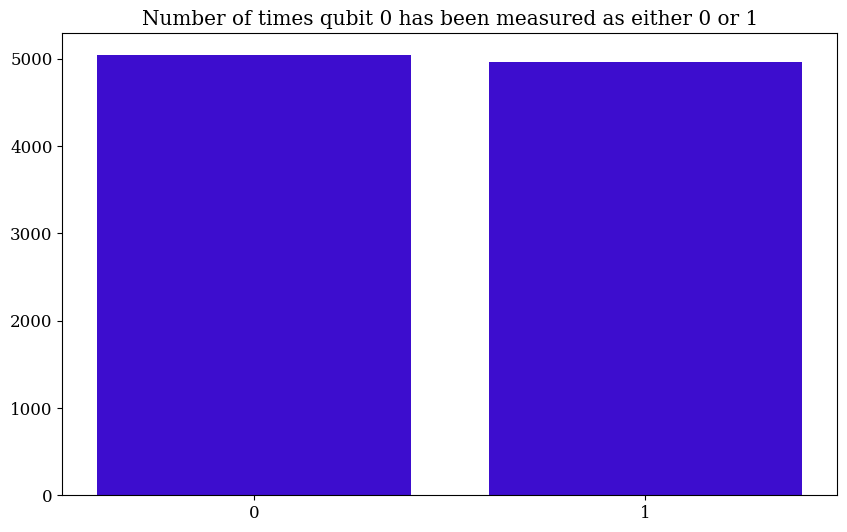

In [12]:
print(f'Odds of measuring qubit 0 as 0:, {q1_results[0]/n_lambdas: .2%}')
print(f'Odds of measuring qubit 0 as 1:, {q1_results[1]/n_lambdas: .2%}')

plt.bar(q1_results.keys(), q1_results.values())
plt.xticks([0, 1])
plt.title("Number of times qubit 0 has been measured as either 0 or 1")
plt.savefig('figs/a_q0_measurement.pdf')
plt.show()

Odds of measuring qubit 0 as 0:,  49.57%
Odds of measuring qubit 0 as 1:,  50.43%


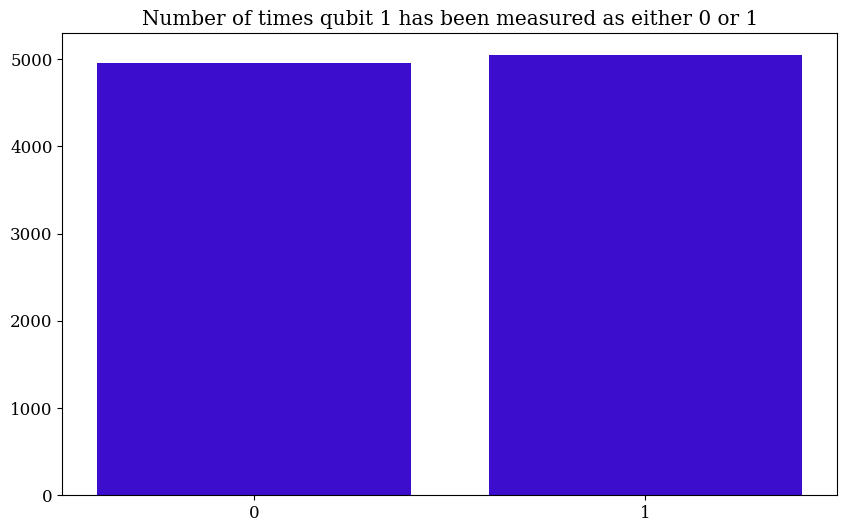

In [ ]:
print(f'Odds of measuring qubit 0 as 0:, {q2_results[0]/n_lambdas: .2%}')
print(f'Odds of measuring qubit 0 as 1:, {q2_results[1]/n_lambdas: .2%}')

plt.bar(q2_results.keys(), q2_results.values())
plt.xticks([0, 1])
plt.title("Number of times qubit 1 has been measured as either 0 or 1")
plt.savefig('figs/a_q1_measurement.pdf')
plt.show()

## <a id='toc4_6_'></a>[Circuit and Measurements in Qiskit](#toc0_)

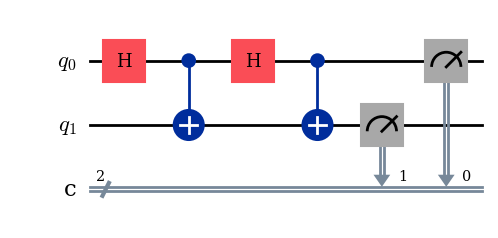

In [ ]:
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.h(0)
qc.cx(0, 1)

# Measureing the qubits
qc.measure(1, 1)
qc.measure(0, 0)
qc.draw('mpl')

CNOT (H|Φ⁺⟩) (Qiskit):
----------------------
Odds of measuring both qubits as 0:                24.68%
Odds of measuring qubit 0 as 0, and qubit 1 as 1:  25.49%
Odds of measuring qubit 0 as 1, and qubit 1 as 0:  25.49%
Odds of measuring both qubits as 1                 24.93%

CNOT (H|Φ⁺⟩) (Python):
----------------------
Odds of measuring both qubits as 0:                25.12%
Odds of measuring qubit 0 as 0, and qubit 1 as 1:  25.42%
Odds of measuring qubit 0 as 1, and qubit 1 as 0:  25.07%
Odds of measuring both qubits as 1:                24.39%


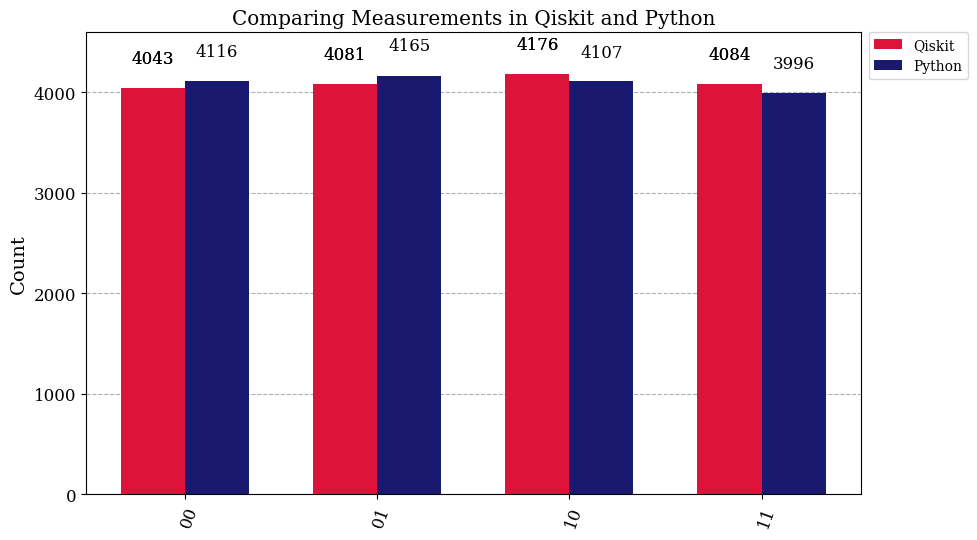

In [ ]:
simulator = AerSimulator()
n_lambdas = 2**14
results_qk = simulator.run(qc, shots=n_lambdas).result().get_counts(qc)
results_qk = dict(sorted(results_qk.items(), key=lambda x: x[0])) # Sort the results by bit string key
q00, q01, q10, q11 = results_qk.values()

print('CNOT (H|Φ⁺⟩) (Qiskit):')
print('----------------------')
print(f'Odds of measuring both qubits as 0:               {q00/n_lambdas: .2%}')
print(f'Odds of measuring qubit 0 as 0, and qubit 1 as 1: {q10/n_lambdas: .2%}')
print(f'Odds of measuring qubit 0 as 1, and qubit 1 as 0: {q10/n_lambdas: .2%}')
print(f'Odds of measuring both qubits as 1                {q11/n_lambdas: .2%}')

# Comparing with python implementation
H = hadamard()
CNOT = cnot()
Φ_00 = create_bell_states()[0]

state = CNOT @ tensor_prod(H, I_2) @ Φ_00

results_py = {f'{i:02b}': 0 for i in range(4)}
for i in range(n_lambdas):
    res = measure_all_qubits(state)
    results_py[res] += 1

q00, q01, q10, q11 = results_py.values()

print()
print('CNOT (H|Φ⁺⟩) (Python):')
print('----------------------')
print(f'Odds of measuring both qubits as 0:               {q00/n_lambdas: .2%}')
print(f'Odds of measuring qubit 0 as 0, and qubit 1 as 1: {q01/n_lambdas: .2%}')
print(f'Odds of measuring qubit 0 as 1, and qubit 1 as 0: {q10/n_lambdas: .2%}')
print(f'Odds of measuring both qubits as 1:               {q11/n_lambdas: .2%}')

%matplotlib inline
fig = plot_histogram([results_qk, results_py], title="Comparing Measurements in Qiskit and Python", 
                                         legend=['Qiskit', 'Python'], 
                                         color=['crimson', 'midnightblue'] )

fig.savefig('figs/a_qiskit_vs_python.pdf')
fig.savefig('selected_results/a_qiskit_vs_python.pdf')

## <a id='toc4_7_'></a>[Conclusion](#toc0_)
- As we can see, the qubit states can be combined to form composite states using the tensor product of $|0⟩$ and $|1⟩$.
- We looked at the bell state $|Φ^{+}⟩$, in which both qubits are either in the state $|0⟩$, represented by $|00⟩$, or $|1⟩$ represented by $|11⟩$. 
- Applying a Hadamard and CNOT gate to $|Φ^{+}⟩$, we get the expected results of approximately a 25% chance of measuring either $|00⟩$, $|01⟩$, $|10⟩$  or $|11⟩$.

# <a id='toc5_'></a>[b)](#toc0_)

## <a id='toc5_1_'></a>[Functions](#toc0_)

In [ ]:
@njit
def Hamiltonian_1qbit(λ: float) -> Array2x2_c:
    '''
    Creates the Hamiltonian for a given interaction strength λ.
    
    Parameters
    ----------
        λ: float
            The interaction strength
    
    Returns
    -------
        H: Array2x2_c
            The complex 2x2 Hamiltonian matrix
    '''
    
    E1 = 0
    E2 = 4
    E = (E1 + E2) / 2
    Ω = (E1 - E2) / 2
    σ_x, σ_y, σ_z = pauli()
    I_2 = np.eye(2, dtype=complex128)
    H0 = E*I_2 + Ω*σ_z

    V11 = 3 
    V22 = -V11 
    V12 = V21 = 0.2
    c = (V11 + V22) / 2
    ω_z = (V11 - V22) / 2
    ω_x = V12
    HI = c*I_2 + ω_z*σ_z + ω_x*σ_x
    
    H = H0 + λ*HI
    return H

## <a id='toc5_2_'></a>[Finding Eigenvalues](#toc0_)

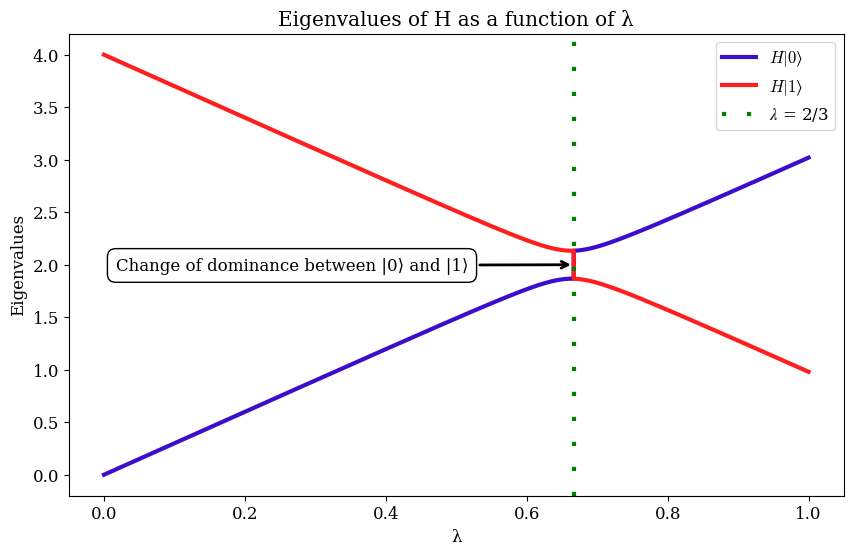

In [ ]:
n_lambdas = 10001
lambdas = np.linspace(0, 1, n_lambdas)
energy_eigvals = [np.linalg.eigvals(Hamiltonian_1qbit(λ)).real for λ in lambdas] # Our Hamiltonian is Hermitian, so the eigenvalues are real. Casting to real to avoid warnings

plt.plot(lambdas, energy_eigvals)

x = 2/3
y = (energy_eigvals[int(2/3*n_lambdas)][0] + energy_eigvals[int(2/3*n_lambdas)][1]) / 2
plt.annotate(text=r"Change of dominance between |0⟩ and |1⟩", 
             xy=(x, y), 
             xytext=(x-.65, y-.05),
             arrowprops=dict(arrowstyle='->', lw=2), 
             bbox=dict(facecolor='white',
             edgecolor='black',
             boxstyle='round,pad=0.5')), 
plt.xlabel('λ')
plt.axvline(x=2/3, color='green', linestyle=(0, (1, 5)))
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues of H as a function of λ')
plt.legend([r'$H|0⟩$', r'$H|1⟩$', r'$λ$ = 2/3'], fontsize='medium')
plt.savefig('figs/b_eigenvalues.pdf')
plt.savefig('selected_results/b_eigenvalues.pdf')
plt.show()


## <a id='toc5_3_'></a>[Conclusion](#toc0_)
- As the interacting term $λ$ increases, naturally, the $|1⟩$ component of the eigenvectors begins to dominate the eigenvalues as it represents the interaction terms. 

# <a id='toc6_'></a>[c)](#toc0_)

## <a id='toc6_1_'></a>[Functions](#toc0_)

In [ ]:
@njit
def Rx(θ: float) -> Array2x2_c:
    '''
    Rotation around the x-axis
    
    Parameters
    ----------
        θ: float
            The angle (radians) to rotate by
    
    Returns
    -------
        Rx: Array2x2_c
            The complex 2x2 rotation matrix
    '''
    I_2 = np.eye(2)
    X = np.array([[0, 1], [1, 0]], dtype=complex128)
    return np.cos(θ*0.5) * I_2-1j * np.sin(θ*0.5) * X

@njit
def Ry(ϕ: float) -> Array2x2_c:
    '''
    Rotation around the y-axisChange of groundstate bewteen energy eigenstate 0 and 2
    
    Parameters
    ----------
        ϕ: float
            The angle (radians) to rotate by
            
    Returns
    -------
        Ry: Array2x2_c
            The complex 2x2 rotation matrix
    '''
    I_2 = np.eye(2)
    Y = np.array([[0, -1j], [1j, 0]])
    return np.cos(ϕ*0.5) * I_2-1j * np.sin(ϕ*0.5) * Y

@njit
def Energy_1qbit(θ: float, ϕ: float, λ: float) -> float:
    '''
    Calculates the energy eigenvalues of the Hamiltonian for a 1-qubit system
    
    Parameters
    ----------
        θ: float
            The angle (radians) to rotate by around the x-axis
        ϕ: float
            The angle (radians) to rotate by around the y-axis
        λ: float
            The interaction strength
            
    Returns
    -------
        E: float
            The energy eigenvalue (real)
    '''
    q0, q1 = qubit_basis()
    q0: Array2D_c = q0.astype(complex128) # Promoted to complex for njit
    
    basis = q0 # |0⟩: Will be rotated anyways so no need to use |1⟩    
    rotated_basis = Rx(θ) @ Ry(ϕ) @ basis
    E = rotated_basis.conj().T @ Hamiltonian_1qbit(λ) @ rotated_basis
    
    assert abs(E.imag) < 1e-14, f'Energy is complex. Something went wrong: E = {E}, type(E) = {type(E)}'
    return E.real

@njit
def VQE_1qbit(n_iterations: int, η: float, λ: float = 0) -> float:
    '''
    Variational Quantum Eigensolver using Gradient Descent to find the minimum energy
    
    Parameters
    ----------
        N_iterations: int
            Number of iterations
        η: float
            Learning rate
        λ: float
            Interaction strength of the Hamiltonian
            
    Returns
    -------
        Energy(θ, ϕ, λ): float
            The lowest energy eigenvalue found in n iterations (real)
    '''
    π = np.pi
    θ = 2*π*np.random.rand()
    ϕ = 2*π*np.random.rand()
    for _ in range(n_iterations):
        ΔE_Δθ = (Energy_1qbit(θ+π/2, ϕ, λ) - Energy_1qbit(θ-π/2, ϕ, λ)) / 2
        ΔE_Δϕ = (Energy_1qbit(θ, ϕ+π/2, λ) - Energy_1qbit(θ, ϕ-π/2, λ)) / 2
        θ -= η * ΔE_Δθ
        ϕ -= η * ΔE_Δϕ
        
    E = Energy_1qbit(θ, ϕ, λ)
    return E

@dataclass
class Benchmark_Results():
    '''
    Dataclass for the benchmark results
    
    Parameters
    ----------
        eig_vals_vqe: ndarray
            The energy eigenvalues found by the VQE algorithm
        eig_vals_numpy: ndarray
            The energy eigenvalues found by numpy
        lambdas: ndarray
            Interaction strengths
        alg_name: str
            The name of the VQE algorithm
        switch_point: float (optional) = None
            The interaction strength where the groundstate changes
    '''
    eig_vals_vqe: ndarray
    eig_vals_numpy: ndarray
    lambdas: ndarray
    alg_name: str
    switch_point: float = None


def benchmark_VQE(VQE_alg: Callable, Hamiltonian: Callable, n_iterations: int, η: float, lambdas: ndarray) -> Benchmark_Results:
    '''
    Benchmarks a VQE algorithm for a given number of iterations and learning rate. Compares the results with numpy
    
    Parameters
    ----------
        VQE_alg: Callable
            The VQE algorithm to benchmark
        Hamiltonian: Callable
            The Hamiltonian to pass to numpy
        n_iterations: int
            Number of iterations
        η: float
            Learning rate
        lambdas: ndarray
            Interaction strengths to benchmark
    
    Returns
    -------
        result: Benchmark_Results
            The benchmark results stored in a dataclass
    '''

    start = time()
    eig_vals_vqe = np.array([VQE_alg(n_iterations, η, λ) for λ in lambdas])
    vqe_time_cold = time() - start
    
    start = time()
    eig_vals_vqe = np.array([VQE_alg(n_iterations, η, λ) for λ in lambdas])
    vqe_time_warm = time() - start
    
    start = time()
    eig_vals_numpy = [np.min(np.linalg.eigvals(Hamiltonian(λ))).real for λ in lambdas] # Our Hamiltonian is Hermitian, so the eigenvalues are real. Casting to real to avoid warnings
    numpy_time = time() - start
    
    name = VQE_alg.__name__
    table = [["Method", "Time (s)", "Times Slower than Numpy"],
             [f"{name} (cold)", f"{vqe_time_cold:.2g}", f"{vqe_time_cold/numpy_time:.2f}"],
             [f"{name} (warm)", f"{vqe_time_warm:.2g}", f"{vqe_time_warm/numpy_time:.2f}"],
             ["Numpy", f"{numpy_time:.2g}", "X"]
    ]
    print(tabulate(table, headers="firstrow", tablefmt="grid"))
    
    result = Benchmark_Results(eig_vals_vqe, eig_vals_numpy, lambdas, name)
    
    return result


def plot_relative_error(result: Benchmark_Results) -> Figure:
    '''
    Plots a comparison between the VQE algorithm and numpy
    
    Parameters
    ----------
        result: Benchmark_Results
            The benchmark results stored in a named tuple
    '''
    eig_vals_vqe = result.eig_vals_vqe
    eig_vals_numpy = result.eig_vals_numpy
    lambdas = result.lambdas
    switch_point = result.switch_point
    alg_name = result.alg_name
    
    warnings.filterwarnings("ignore", category=RuntimeWarning) # Ignore RuntimeWarning for division by zero
    relative_error = (eig_vals_vqe - eig_vals_numpy) / eig_vals_numpy
    warnings.filterwarnings("default", category=RuntimeWarning) # Turn warning back on
    
    plt.plot(lambdas, relative_error, label=f'Relative error between {alg_name}  and Numpy')
    
    plt.axvline(x=switch_point, color='green', linestyle=(0, (1, 5)), label=f'λ = {switch_point: .3f}')
    
    width = 1/15
    plt.axvspan(switch_point - width, switch_point + width , color='red', alpha=0.2, label='Area of larger error')
    
    zeros = np.where(relative_error == 0)[0]
    if len(zeros) > 0:
        plt.scatter(lambdas[zeros], relative_error[zeros], color='black', label='Zero relative error')
    
    plt.xlabel('λ')
    plt.ylabel('Relative error')
    
    percentage_formatter = lambda x, _: f'{x*100:1g}%'
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(percentage_formatter))
    plt.legend()
    
    return plt.gcf()
    
def plot_eigvals(result: Benchmark_Results) -> Figure:
    '''
    Plots a comparison between the VQE algorithm and numpy
    
    Parameters
    ----------
        result: Benchmark_Results
            The benchmark results stored in a named tuple
    '''
    eig_vals_vqe = result.eig_vals_vqe
    eig_vals_numpy = result.eig_vals_numpy
    lambdas = result.lambdas
    switch_point = result.switch_point
    alg_name = result.alg_name
    
    plt.plot(lambdas, eig_vals_vqe, label=f'{alg_name}')
    plt.plot(lambdas, eig_vals_numpy, label='Numpy', linestyle='--')
    
    plt.axvline(x=switch_point, color='green', linestyle=(0, (1, 5)), label=f'λ = {switch_point: .3f}')
    plt.xlabel('λ')
    plt.ylabel('Energy eigenvalues')
    plt.legend(fontsize = 'medium')
    
    return plt.gcf()

## <a id='toc6_2_'></a>[Comparing VQE and Exact Eigenvalues](#toc0_)

In [ ]:
n_iterations = 100
η = 1/2
n_lambdas = 100
lambdas = np.linspace(0, 1, n_lambdas)

result_1qbit: Benchmark_Results = benchmark_VQE(VQE_1qbit, Hamiltonian_1qbit, n_iterations, η, lambdas)

switch_point = 2/3
result_1qbit.switch_point = switch_point

+------------------+------------+---------------------------+
| Method           |   Time (s) | Times Slower than Numpy   |
+==================+============+===========================+
| VQE_1qbit (cold) |    2.2     | 2316.11                   |
+------------------+------------+---------------------------+
| VQE_1qbit (warm) |    0.054   | 57.98                     |
+------------------+------------+---------------------------+
| Numpy            |    0.00094 | X                         |
+------------------+------------+---------------------------+


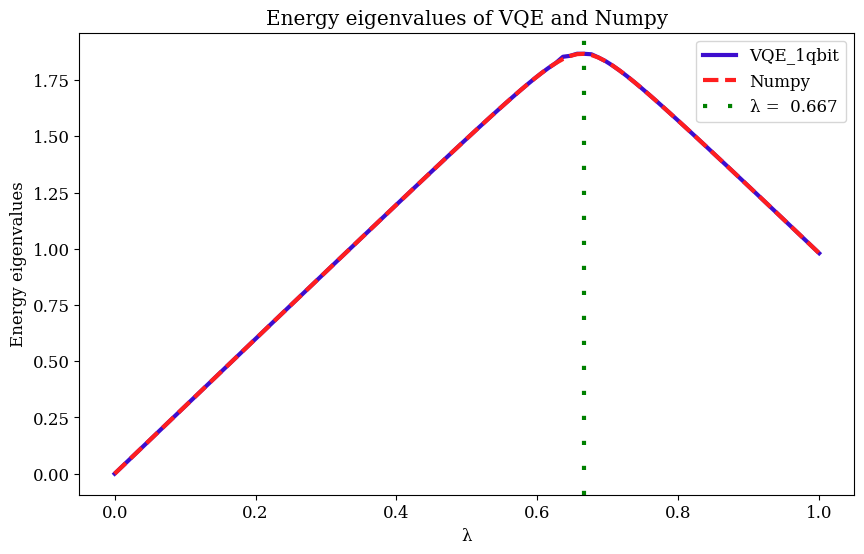

In [20]:

fig = plot_eigvals(result_1qbit)
plt.title('Energy eigenvalues of VQE and Numpy')
plt.savefig('figs/c_vqe_vs_numpy.pdf')
plt.show()

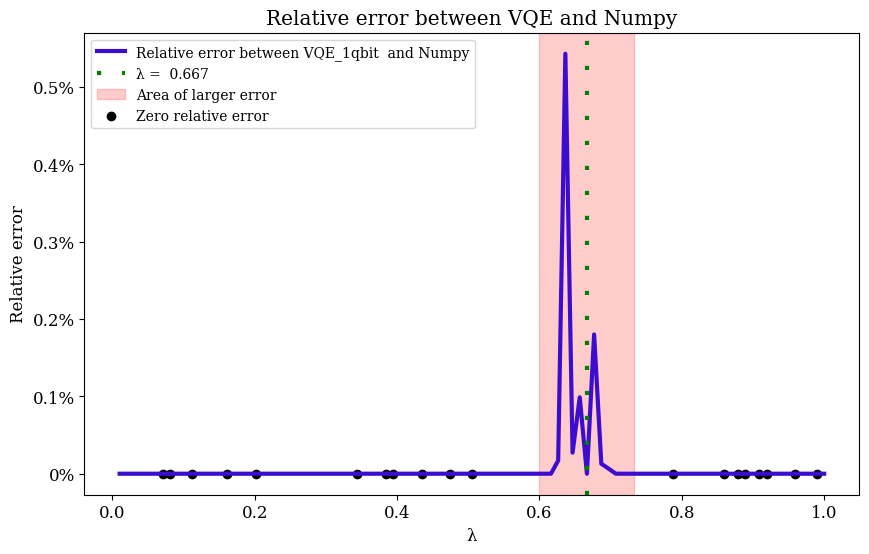

In [ ]:
fig = plot_relative_error(result_1qbit)
plt.title('Relative error between VQE and Numpy')
plt.savefig('figs/c_relative_error.pdf')
plt.show()

## <a id='toc6_3_'></a>[Conclusion](#toc0_)
- As we can see, the VQE method is able to approximate the eigenvalues of the Hamiltonian matrix, with a relative error of $≈ 10^{-6}\%$
- With 128 iterations, the VQE was  $≈ 2000$ times slower on a cold start than the exact eigenvalue method. After jit compilation, it was only $≈ 80-90$ times slower.  How this scales with larger matrices is currently unknown.
- Larger error around the $λ = 2/3$ region, might not be a coincidence.

# <a id='toc7_'></a>[d)](#toc0_)

## <a id='toc7_1_'></a>[Functions](#toc0_)

In [ ]:

@njit
def Hamiltonian_2qbit(λ: float) -> Array4x4_c:
    '''
    Creates the Hamiltonian for a given interaction strength λ.
    
    Parameters
    ----------
        λ: float
            The interaction strength
    
    Returns
    -------
        H: Array4x4_c
            The complex 4x4 Hamiltonian matrix
    '''
    ε00, ε10, ε01, ε11 = 0.0, 2.5, 6.5, 7.0
    # np.diag not supported by numba
    H0: Array2x2 = np.array([[ε00, 0, 0, 0], 
                             [0, ε10, 0, 0], 
                             [0, 0, ε01, 0], 
                             [0, 0, 0, ε11]], dtype=complex128)
    Hx = 2 
    Hz = 3
    σ_x, σ_y, σ_z = pauli()
    HI: Array2x2 = tensor_prod(Hx*σ_x, σ_x) + tensor_prod(Hz*σ_z, σ_z)
    
    H:  Array2x2 = H0 + λ*HI
    
    return H

def density_matrix_groundstate(λ: float) -> Array4x4:
    '''
    Creates the density matrix of the lowest energy state
    
    Parameters
    ----------
        λ: float
            The interaction strength
    
    Returns
    -------
        ρ0: Array4x4
            The density matrix of the lowest energy state
    '''
    H = Hamiltonian_2qbit(λ)
    ψ_0: Array4D = np.linalg.eigh(H)[1][:, 0]
    
    ρ0: Array4x4 = np.outer(ψ_0, ψ_0.conj())
    return ρ0

def partial_trace(qubit: Indexing_2qbit, ρ: Array4x4) -> float:
    '''
    Partial trace over qubit
    
    Parameters
    ----------
        qubit: int
            Which qubit to trace over. Uses 0-based indexing
        ρ: Array4x4
            The density matrix
            
    Returns
    -------
        Tr(ρ_partial): float
            The partial trace of the density matrix
    '''
    q0, q1 = create_system_vectors(1)
    I_2 = np.eye(2)
    
    if qubit == 0:
        op0 = tensor_prod(q0, I_2)
        op1 = tensor_prod(q1, I_2)
    
    elif qubit == 1:
        op0 = tensor_prod(I_2, q0)
        op1 = tensor_prod(I_2, q1)
    
    else:
        raise ValueError('qubit must be 0 or 1')
    
    return op0.conj() @ ρ @ op0.T + op1.conj() @ ρ @ op1.T
    
    
def entropy(λ: float, ε: float = 1e-12) -> float:
    '''
    Calculates the entropy of the reduced density matrix
    
    Parameters
    ----------
        λ: float
            The interaction strength
        ε: float (optional)
            Small value to avoid log(0). Default is 1e-12
        
    Returns
    -------
        S: float
            The entropy of the reduced density matrix
    '''
    ρ0 = density_matrix_groundstate(λ)
    ρ_A = partial_trace(0, ρ0)
    S = -np.trace(ρ_A @ np.log2(ρ_A + ε))
    
    # Sanity check
    assert np.iscomplex(S) == False, f'Entropy is complex. Something went wrong: S = {S}, type(S) = {type(S)}'
    return S.real    

### <a id='toc7_1_1_'></a>[Analytical Solution](#toc0_)

#### <a id='toc7_1_1_1_'></a>[Using SymPy](#toc0_)

In [ ]:
ε00, ε01, ε10, ε11 = sp.symbols('ε00 ε01 ε10 ε11')
λ = sp.symbols('λ')
Hx, Hz = sp.symbols('Hx Hz')
H = sp.Matrix([[ε00 + λ*Hz, 0         , 0         , λ*Hz],
               [0         , ε10 - λ*Hz, λ*Hx      , 0],
               [0         , λ*Hx      , ε01 - λ*Hz, 0],
               [λ*Hx      , 0         , 0         , ε11 + λ*Hz]])

eigvecs_and_vals = H.eigenvects()
eigvals = [eigvec[0] for eigvec in eigvecs_and_vals]
eigvecs = [eigvec[2][0] for eigvec in eigvecs_and_vals]

In [ ]:
for i, (eigval, eigvec) in enumerate(zip(eigvals, eigvecs)):
    print(f'Eigenvalue {i}:')
    display(sp.simplify(eigval))
    print(f'Eigenvector {i}:')
    display(sp.simplify(eigvec), )
    print('--'*24)
    print()


Eigenvalue 0:


-Hz*λ + ε01/2 + ε10/2 - sqrt(4*Hx**2*λ**2 + ε01**2 - 2*ε01*ε10 + ε10**2)/2

Eigenvector 0:


Matrix([
[                                                                       0],
[(-ε01 + ε10 - sqrt(4*Hx**2*λ**2 + ε01**2 - 2*ε01*ε10 + ε10**2))/(2*Hx*λ)],
[                                                                       1],
[                                                                       0]])

------------------------------------------------

Eigenvalue 1:


-Hz*λ + ε01/2 + ε10/2 + sqrt(4*Hx**2*λ**2 + ε01**2 - 2*ε01*ε10 + ε10**2)/2

Eigenvector 1:


Matrix([
[                                                                       0],
[(-ε01 + ε10 + sqrt(4*Hx**2*λ**2 + ε01**2 - 2*ε01*ε10 + ε10**2))/(2*Hx*λ)],
[                                                                       1],
[                                                                       0]])

------------------------------------------------

Eigenvalue 2:


Hz*λ + ε00/2 + ε11/2 - sqrt(4*Hx*Hz*λ**2 + ε00**2 - 2*ε00*ε11 + ε11**2)/2

Eigenvector 2:


Matrix([
[(ε00 - ε11 - sqrt(4*Hx*Hz*λ**2 + ε00**2 - 2*ε00*ε11 + ε11**2))/(2*Hx*λ)],
[                                                                      0],
[                                                                      0],
[                                                                      1]])

------------------------------------------------

Eigenvalue 3:


Hz*λ + ε00/2 + ε11/2 + sqrt(4*Hx*Hz*λ**2 + ε00**2 - 2*ε00*ε11 + ε11**2)/2

Eigenvector 3:


Matrix([
[(ε00 - ε11 + sqrt(4*Hx*Hz*λ**2 + ε00**2 - 2*ε00*ε11 + ε11**2))/(2*Hx*λ)],
[                                                                      0],
[                                                                      0],
[                                                                      1]])

------------------------------------------------



#### <a id='toc7_1_1_2_'></a>[Using the Results from Above](#toc0_)

In [ ]:
def analytical_energy_eigenstates(λ: float) -> tuple[Array4D, Array4D, Array4D, Array4D]:
    '''
    Calculates the energy eigenstates of the Hamiltonian using the analytical solution
    
    Parameters
    ----------
        λ: float
            The interaction strength
    
    Returns
    -------
        eigenstates: tuple[Array4x4, Array4x4, Array4x4, Array4x4]
            The energy eigenstates. The order is the same as the energy eigenvalues in `energy_eigenvalues()`
    '''
    Hx = 2 
    Hz = 3
    ε00, ε10, ε01, ε11 = 0, 2.5, 6.5, 7
    q00, q01, q10, q11 = create_system_vectors(2)
    
    sqrt1 = np.sqrt(4*(λ*Hx)**2 + ε11**2 - 2*ε11*ε00 + ε00**2)
    sqrt2 = np.sqrt(4*(λ*Hx)**2 + ε10**2 - 2*ε10*ε01 + ε01**2)
    
    
    warnings.filterwarnings('ignore', category=RuntimeWarning) # Suppress RuntimeWarnings for the division by zero
    
    v00: Array4D_c = q00 * -(ε11 - ε00 + sqrt1)/(2*λ*Hx) + \
                           q01 * 0 +                             \
                           q10 * 0 +                             \
                           q11 * 1
    
    v01: Array4D_c = q00 * -(ε11 - ε00 - sqrt1)/(2*λ*Hx) + \
                           q01 * 0 +                             \
                           q10 * 0 +                             \
                           q11 * 1
          
    v10: Array4D_c = q00 * 0 +                              \
                           q01 * -(-ε10 + ε01 + sqrt2)/(2*λ*Hx) + \
                           q10 * 1 +                              \
                           q11 * 0
          
    v11: Array4D_c = q00 * 0 +                              \
                           q01 * -(-ε10 + ε01 - sqrt2)/(2*λ*Hx) + \
                           q10 * 1 +                              \
                           q11 * 0
    
    warnings.filterwarnings('default', category=RuntimeWarning) # Reset warnings
    
    # Normalizing the vectors
    v00: Array4D = v00 / np.linalg.norm(v00)
    v01: Array4D = v01 / np.linalg.norm(v01)
    v10: Array4D = v10 / np.linalg.norm(v10)
    v11: Array4D = v11 / np.linalg.norm(v11)
    
    return v00, v01, v10, v11


def analytical_energy_eigenvalues(λ: float) -> tuple[float, float, float, float]:
    '''
    Calculates the energy eigenvalues of the Hamiltonian using the analytical solution
    
    Parameters
    ----------
        λ: float
            The interaction strength
    
    Returns
    -------
        eigenvalues: tuple[float, float, float, float]
            The energy eigenvalues. The order is the same as the energy eigenstates in `energy_eigenstates()`
    '''
    Hx = 2 
    Hz = 3
    ε00, ε10, ε01, ε11 = 0, 2.5, 6.5, 7
    sqrt1 = np.sqrt(ε00**2 - 2*ε00*ε11 + 4*(λ*Hx)**2 + ε11**2)
    sqrt2 = np.sqrt(ε01**2 - 2*ε01*ε10 + 4*(λ*Hx)**2 + ε10**2)
    
    
    eigval_00 = 1/2 * (-sqrt1 + ε00 + 2*λ*Hz + ε11)
    eigval_01 = 1/2 * ( sqrt1 + ε00 + 2*λ*Hz + ε11)
    eigval_10 = 1/2 * (-sqrt2 + ε01 - 2*λ*Hz + ε10)
    eigval_11 = 1/2 * ( sqrt2 + ε01 - 2*λ*Hz + ε10)
        
    return eigval_00, eigval_01, eigval_10, eigval_11


def entropy_state(state: Literal[0, 1, 2, 3], λ: float, ε: float = 1e-12) -> float:
    '''
    Calculates the entropy for a given energy eigenstate 
    
    Parameters
    ----------
        state: int
            The state to find the entropy of. Uses 0-based indexing
        λ: float
            The interaction strengths
        ε: float (optional)
            Small value to avoid log(0). Default is 1e-12
    Returns
    -------
        S: float
            The entropy of the reduced density matrix for the original ground state
    '''
    
    ψ: Array4D  = analytical_energy_eigenstates(λ)[state]
    ρ: Array4x4 = np.outer(ψ, ψ.conj())
    
    ρ_A = partial_trace(0, ρ)
    S = -np.trace(ρ_A @ np.log2(ρ_A + ε))
    
    # Sanity check
    assert np.iscomplex(S) == False, f'Entropy is complex. Something went wrong: S = {S}, type(S) = {type(S)}'
    return S.real        

## <a id='toc7_2_'></a>[Plotting Energy and Entropy](#toc0_)

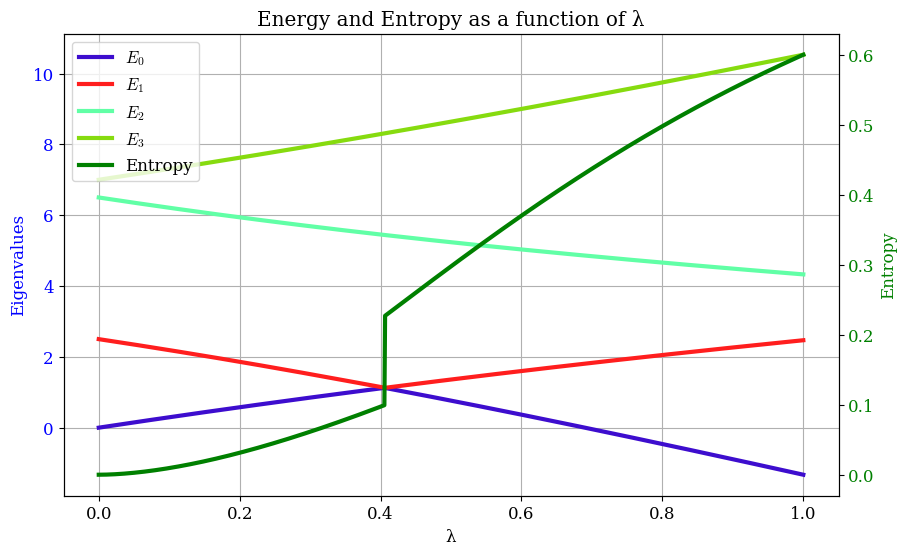

In [ ]:
n_lambdas = 1000
lambdas = np.linspace(0, 1, n_lambdas)
energy_eigvals = [np.linalg.eigvalsh(Hamiltonian_2qbit(λ)) for λ in lambdas]
entropies = [entropy(λ) for λ in lambdas]

plt.plot(lambdas, energy_eigvals, label=['$E_0$', '$E_1$', '$E_2$', '$E_3$'])
lines_energy, labels_energy = plt.gca().get_legend_handles_labels()
plt.xlabel('λ')
plt.ylabel('Eigenvalues', color='blue')
plt.yticks(color='blue')
plt.grid()

plt.twinx()

plt.plot(lambdas, entropies, color='green', label='Entropy')
lines_entropy, labels_entropy = plt.gca().get_legend_handles_labels()
plt.ylabel('Entropy', color='green')
plt.yticks(color='green')

plt.title('Energy and Entropy as a function of λ')
plt.legend(lines_energy + lines_entropy, labels_energy + labels_entropy, fontsize='medium')
plt.savefig('figs/d_energy_entropy.pdf')
plt.savefig('selected_results/d_energy_entropy.pdf')
plt.show()

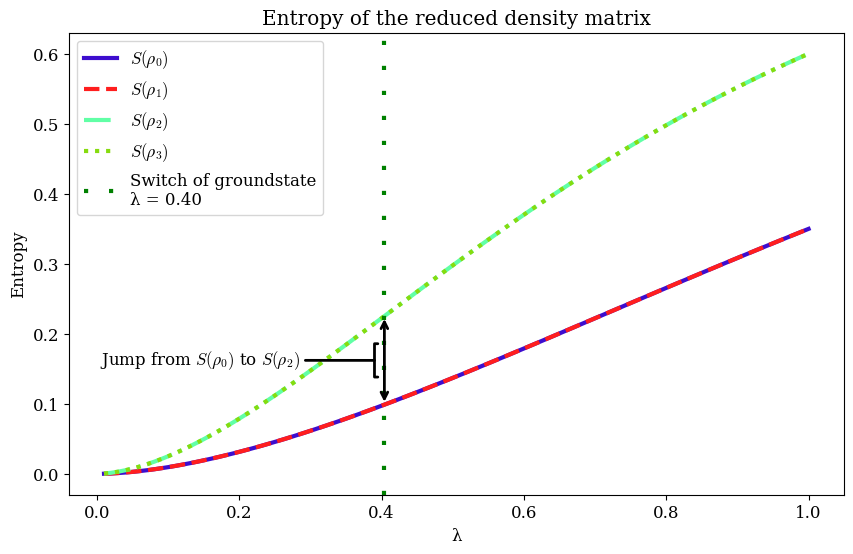

In [ ]:
n_lambdas = 100
lambdas = np.linspace(0, 1, n_lambdas)
entropy_0 = [entropy_state(0, λ) for λ in lambdas]
entropy_1 = [entropy_state(1, λ) for λ in lambdas]
entropy_2 = [entropy_state(2, λ) for λ in lambdas]
entropy_3 = [entropy_state(3, λ) for λ in lambdas]

energy_eigvals = np.array([analytical_energy_eigenvalues(λ) for λ in lambdas])

E0 = energy_eigvals[:, 0]
E1 = energy_eigvals[:, 2] # Energy is not sorted the same way as the entropy

switch_point_idx = np.argmin(np.abs(E0 - E1))
gap = entropy_2[switch_point_idx] - entropy_0[switch_point_idx]

plt.plot(lambdas, entropy_0, label=r'$S(ρ_0)$', linewidth = 3, linestyle='-')
plt.plot(lambdas, entropy_1, label=r'$S(ρ_1)$', linewidth = 3, linestyle='--')
plt.plot(lambdas, entropy_2, label=r'$S(ρ_2)$', linewidth = 3, linestyle='-.')
plt.plot(lambdas, entropy_3, label=r'$S(ρ_3)$', linewidth = 3, linestyle=':')
plt.axvline(x=lambdas[switch_point_idx], color='green', linestyle=(0, (1, 5)), label=f'Switch of groundstate\nλ = {lambdas[switch_point_idx]:.2f}')
plt.ylabel('Entropy')
plt.xlabel('λ')
plt.title('Entropy of the reduced density matrix')
plt.legend(fontsize='medium')

plt.annotate(text="",
             xy=(lambdas[switch_point_idx], entropy_0[switch_point_idx]),
             xytext=(lambdas[switch_point_idx], entropy_0[switch_point_idx] + gap),
             arrowprops=dict(arrowstyle='<->', lw=2)
            )

plt.annotate(text="Jump from $S(ρ_0)$ to $S(ρ_2)$",
                xy=(lambdas[switch_point_idx]-.01, entropy_0[switch_point_idx] + gap/2),
                xytext=(lambdas[switch_point_idx] - 0.4, entropy_0[switch_point_idx] + gap/2*.9),
                arrowprops=dict(arrowstyle='-[', lw=2)
             )

plt.savefig('figs/d_entropy.pdf')
plt.show()

## <a id='toc7_3_'></a>[Conclusion](#toc0_)
- As the interaction strength $λ$ increases, we see a switch in which the lowest energy state switches from $|ψ_{00}⟩$ with corresponding eigenvalue $E_0$, to $|ψ_{01}⟩$ with corresponding eigenvalue $E_1$. 
- When calculating entropy, we always look at the lowest energy state. After the switch from $|ψ_{00}⟩$ to $|ψ_{01}⟩$, we switch what state we calculate the entropy from. As these two states have different entropies, the entropy makes a sudden jump at the point of the switch.

# <a id='toc8_'></a>[e)](#toc0_)

## <a id='toc8_1_'></a>[Functions](#toc0_)

In [ ]:
@njit
def Energy_2qbit(θ1: float, θ2: float, θ3: float, θ4: float, λ: float) -> float:
    '''
    Calculates the energy eigenvalues of the Hamiltonian for a 2-qubit system
    
    Parameters
    ----------
        θ1: float
            The angle (radians) to rotate by around the x-axis of qubit 0
        θ2: float
            The angle (radians) to rotate by around the y-axis of qubit 0
        θ3: float
            The angle (radians) to rotate by around the x-axis of qubit 1
        θ4: float
            The angle (radians) to rotate by around the y-axis of qubit 1
        λ: float
            The interaction strength
    
    Returns
    -------
        E: float
            The energy eigenvalue (real part)
    '''
    R1:   Array2x2_c = Rx(θ1) @ Ry(θ2)
    R2:   Array2x2_c = Rx(θ3) @ Ry(θ4)
    CNOT: Array4x4_c = cnot()
    
    basis = np.array([1, 0, 0, 0], dtype=complex128) # |00⟩: Will be rotated anyways so no need to use |01⟩, |10⟩ or |11⟩
    rotated_basis: Array4x4_c = CNOT @ tensor_prod(R1, R2) @ basis
    E = rotated_basis.conj().T @ Hamiltonian_2qbit(λ) @ rotated_basis
    
    assert abs(E.imag) < 1e-14  , f'Energy is complex. Something went wrong: E = {E}, type(E) = {type(E)}'
    return E.real

@njit
def VQE_2qbit(N: int, η: float, λ: float = 0) -> float:
    '''
    Variational Quantum Eigensolver using Gradient Descent to find the minimum energy
    
    Parameters
    ----------
        N: int
            Number of iterations
        η: float
            Learning rate
        λ: float
            Interaction strength of the Hamiltonian
            
    Returns
    -------
        Energy(θ1, θ2, θ3, θ4, λ): float
            The energy eigenvalue (real part)
    '''
    π = np.pi
    θ1 = 2*π*np.random.rand()
    θ2 = 2*π*np.random.rand()
    θ3 = 2*π*np.random.rand()
    θ4 = 2*π*np.random.rand()
    
    # More compact to rename function
    E: Callable = Energy_2qbit
    for _ in range(N):
        ΔE_Δθ1 = (E(θ1+π/2, θ2, θ3, θ4, λ) - E(θ1-π/2, θ2, θ3, θ4, λ)) / 2
        ΔE_Δθ2 = (E(θ1, θ2+π/2, θ3, θ4, λ) - E(θ1, θ2-π/2, θ3, θ4, λ)) / 2
        ΔE_Δθ3 = (E(θ1, θ2, θ3+π/2, θ4, λ) - E(θ1, θ2, θ3-π/2, θ4, λ)) / 2
        ΔE_Δθ4 = (E(θ1, θ2, θ3, θ4+π/2, λ) - E(θ1, θ2, θ3, θ4-π/2, λ)) / 2
        
        θ1 -= η * ΔE_Δθ1
        θ2 -= η * ΔE_Δθ2
        θ3 -= η * ΔE_Δθ3
        θ4 -= η * ΔE_Δθ4
    
    # Using the actual function name
    E = Energy_2qbit(θ1, θ2, θ3, θ4, λ)
    return E

## <a id='toc8_2_'></a>[Comparing VQE and Exact Eigenvalues](#toc0_)

In [ ]:
n_iterations = 400
η = 1/4
n_lambdas = 100
lambdas = np.linspace(0, 1, n_lambdas)

result_2qbit: Benchmark_Results = benchmark_VQE(VQE_2qbit, Hamiltonian_2qbit, n_iterations, η, lambdas)

energy_eigvals = np.array([analytical_energy_eigenvalues(λ) for λ in lambdas])
E0 = energy_eigvals[:, 0]
E1 = energy_eigvals[:, 2] # Energy is not sorted the same way as the entropy

switch_point_idx = np.argmin(np.abs(E0 - E1))
switch_point = lambdas[switch_point_idx]

result_2qbit.switch_point = switch_point

+------------------+------------+---------------------------+
| Method           |   Time (s) | Times Slower than Numpy   |
+==================+============+===========================+
| VQE_2qbit (cold) |     2.9    | 2300.59                   |
+------------------+------------+---------------------------+
| VQE_2qbit (warm) |     1.4    | 1140.17                   |
+------------------+------------+---------------------------+
| Numpy            |     0.0012 | X                         |
+------------------+------------+---------------------------+


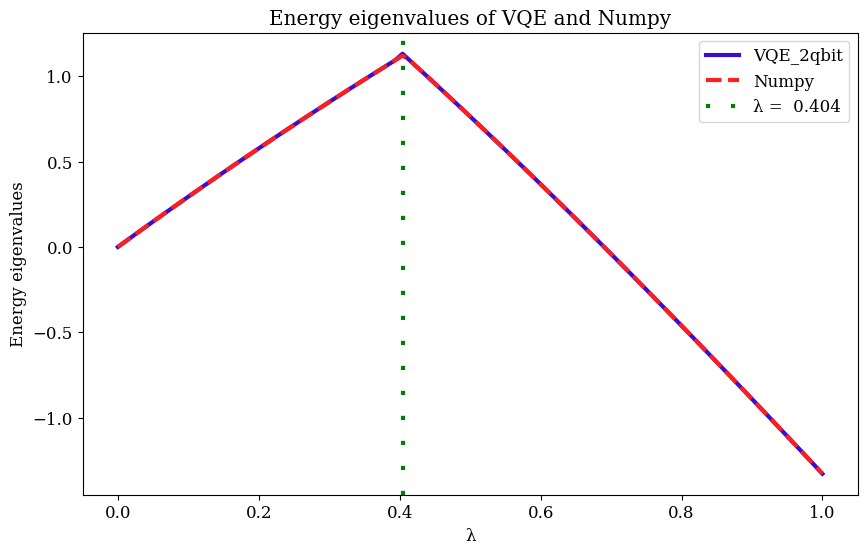

In [30]:
fig = plot_eigvals(result_2qbit)
plt.title('Energy eigenvalues of VQE and Numpy')
plt.savefig('figs/e_vqe_vs_numpy.pdf')
plt.show()

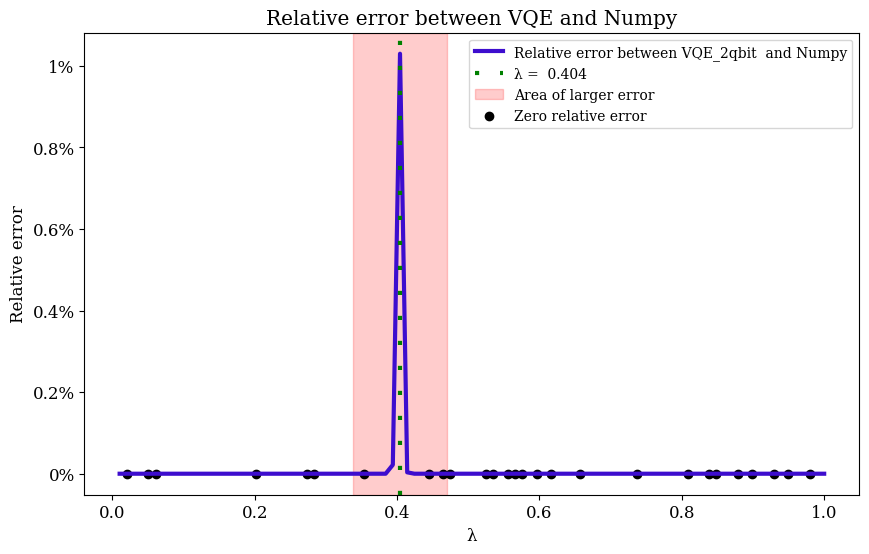

In [ ]:
fig = plot_relative_error(result_2qbit)
plt.title('Relative error between VQE and Numpy')
plt.savefig('figs/e_relative_error.pdf')
plt.show()

## <a id='toc8_3_'></a>[Conclusion](#toc0_)
- The VQE method was 500-1000 times slower than using numpy, as opposed to 50-80 times slower in the 1 qubit case. 
    - This might not be surprising as one needs to preform the gradient descent which can't be done in parallel
    - The 2 qubit case involves twice as large matrices and vectors.   
- The VQE method for the 2 qubit case needed 4 times the number of iterations to get the same relative error as in the 1 qubit case of about $1\%$
- There was about one order of magnitude difference in the performance of the VQE method between the 1 and 2 qubit case, compared to using numpy.
- The algorithm could be improved by doing more iterations if the interaction strength $λ$ is near the point where the eigenvalues switch.